In [2]:
import cv2
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

import utils

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.38 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages
DEBUG:nodes:version 6.2.13 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages pyparsing 3.0.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}


In [3]:
plt.rcParams['figure.figsize'] = [7, 7]

INFO:duckietown_world: data: /home/giulio/prog/.virtualenvs/RACE/lib/python3.8/site-packages/duckietown_world/data
/home/giulio/prog/duckrace/utils.py:363: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


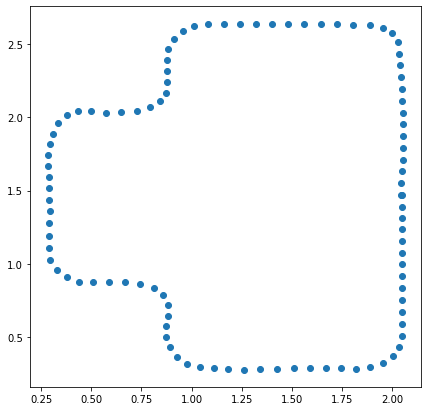

In [4]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
)

env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], -np.pi/2]
env.reset()

traj = utils.get_trajectory(env, samples=100, method="distance", last_value_distance=1.035)
plt.scatter(*traj.T)

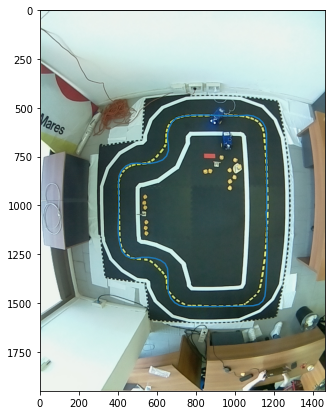

In [27]:
import copy

img = cv2.imread("assets/lab_wt.png")
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

scale_x, scale_y, offset_x, offset_y = utils.calibration_params(traj, img)

plt.imshow(img_rgb)
plt.plot(*utils.use_calibration(copy.deepcopy(traj), scale_x=scale_x, scale_y=scale_y, offset_x=offset_x, offset_y=offset_y).T)

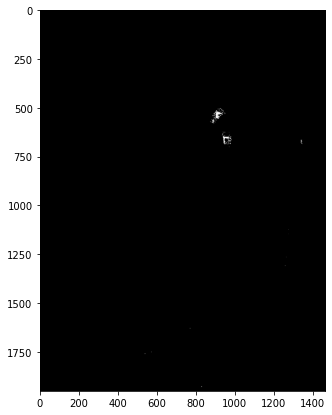

In [6]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_color1 = np.array([100, 100, 130])
hsv_color2 = np.array([110, 250, 170])

mask = cv2.inRange(img_hsv, hsv_color1, hsv_color2)

plt.imshow(mask, cmap='gray')

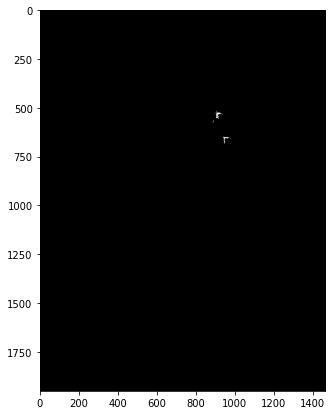

In [54]:
kernel = np.ones((2,2), np.uint8)
img_erosion = cv2.erode(mask, kernel, iterations=2)
plt.imshow(img_erosion, cmap='gray')

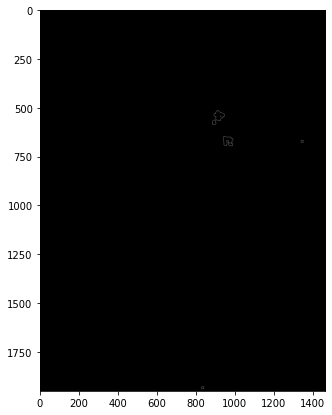

In [55]:
img_dilation = cv2.dilate(img_erosion, kernel, iterations=10)
plt.imshow(cv2.Canny(img_dilation,50,100), cmap='gray')

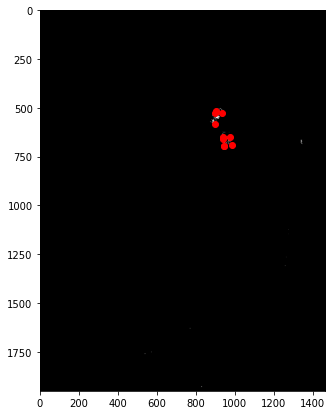

In [58]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 90  # angular resolution in radians of the Hough grid
threshold = 20  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20  # minimum number of pixels making up a line
max_line_gap = 15  # maximum gap in pixels between connectable line segments

# cv2.Canny(img_dilation,100,200)
lines = cv2.HoughLinesP(cv2.Canny(img_dilation,50,100), rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

_points = lines.reshape(-1, 2)

x, y = _points.T
plt.scatter(x, y, zorder=1, color="r")
plt.imshow(mask, zorder=0, cmap='gray')

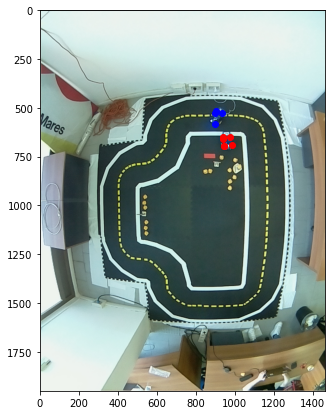

In [92]:
filt = ((_points - _points[0])**2).sum(1) < 70**2
plt.scatter(*_points[filt].T, c="r")
plt.scatter(*_points[~filt].T, c="b")
plt.imshow(img_rgb)

In [93]:
def get_cars(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_color1 = np.array([100, 100, 130])
    hsv_color2 = np.array([110, 250, 170])

    mask_blue = cv2.inRange(img_hsv, hsv_color1, hsv_color2)
    kernel = np.ones((2,2), np.uint8)
    img_erosion = cv2.erode(mask_blue, kernel, iterations=2)
    img_dilation = cv2.dilate(img_erosion, kernel, iterations=10)
    rho = 1  # distance resolution in pixels of the Hough grid

    theta = np.pi / 90  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 15  # maximum gap in pixels between connectable line segments

    # cv2.Canny(img_dilation,100,200)
    lines = cv2.HoughLinesP(cv2.Canny(img_dilation,50,100), rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    _points = lines.reshape(-1, 2)

    filt = ((_points - _points[0])**2).sum(1) < 70**2

    return _points[filt], _points[~filt]

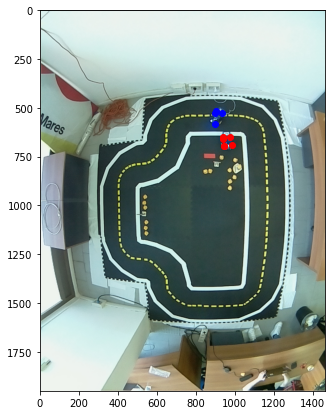

In [95]:
first, second = get_cars(img)
plt.imshow(img_rgb)
plt.scatter(*first.T, c="r")
plt.scatter(*second.T, c="b")